## Import modules

In [1]:
import os
import numpy as np
import math
import statistics
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline

## Load output test probabilitites and true labels for each model

For every model there are 2 files generated in numpy binary format:

  **probabilities.npy** - numpy array of size **TEST POINT CLOUDS CLOUD x CLASSES COUNT x MODELS COUNT** with output classification probability for each of 10 individually trained models

  **true_labels.npy** - numpy array of size **TEST POINT CLOUDS CLOUD** with true labels data

In [2]:
BASE_MODELS = ['pointnet', 'pointnet++', 'so-net', 'kcnet'] #, 'deepsets']
SONET_BAGGIBG_MODELS = ['so-net_sz_01', 'so-net_sz_02', 'so-net_sz_03', 'so-net_sz_07']
ALL_MODELS = BASE_MODELS + SONET_BAGGIBG_MODELS

CLASS_NAMES = ['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl',
               'car', 'chair', 'cone', 'cup', 'curtain', 'desk', 'door', 'dresser',
               'flower_pot', 'glass_box', 'guitar', 'keyboard', 'lamp', 'laptop',
               'mantel', 'monitor', 'night_stand', 'person', 'piano', 'plant', 'radio',
               'range_hood', 'sink', 'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet',
               'tv_stand', 'vase', 'wardrobe', 'xbox']
CLASS_TEST_INSTANCES = [100, 50, 100, 20, 100, 100, 20, 100, 100, 20, 20, 20, 86, 20,
                        86, 20, 100, 100, 20, 20, 20, 100, 100, 86, 20, 100, 100, 20,
                        100, 20, 100, 20, 20, 100, 20, 100, 100, 100, 20, 20]
CLASSES_COUNT = 40
MODELS_COUNT = 10
ENSEMBLE_MODELS_NUMBER = 10

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

probabilities = {}
true_labels = {}
for model in ALL_MODELS:
    prob_filepath = os.path.join(model, 'probabilities.npy')
    probabilities[model] = np.load(prob_filepath)
    probabilities[model] = np.transpose(probabilities[model], axes=(2, 0, 1))

    # probabilities[model] =  softmax(probabilities[model])
    probabilities[model] = probabilities[model]/np.std(probabilities[model])

    label_filepath = os.path.join(model, 'true_labels.npy')
    true_labels[model] = np.load(label_filepath)
    for class_idx in range(CLASSES_COUNT):
        error_info = ("Test cloud instances for model " + model + " and class "
                      + str(class_idx) + " differs! Should be " + str(CLASS_TEST_INSTANCES[class_idx])
                      + " but got " + str(np.sum(true_labels[model] == class_idx)))
        assert np.sum(true_labels[model] == class_idx) == CLASS_TEST_INSTANCES[class_idx], error_info
                

    assert (probabilities[model].shape[0] == ENSEMBLE_MODELS_NUMBER)
    assert (probabilities[model].shape[1] == 2468)
    assert (probabilities[model].shape[2] == CLASSES_COUNT)

## Caclulate statistics

In [3]:
####################################################################################
# Get random subsets
####################################################################################

def get_k_combinations_of_n_elems(n, k, rep):
    """
    Get rep different k-combinations of set of n numbers. If requested reps is greater
    than possible combinations number just return all possible combinations. In our case:
    n - maximum number of ensembled models
    k - actual number of ensembled models
    rep - how many different k subsets of n we want to generate.    
    """
    c_n_k = math.factorial(n) / math.factorial(k) / math.factorial(n-k)
    combinations_number = min(c_n_k, rep)
    
    subsets = []   
    while len(subsets) != combinations_number:
        candidate = np.sort(np.random.choice(n, k, replace=False))
        if not np.array([(el == candidate).all() for el in subsets]).any():
            subsets.append(candidate)
    return np.array(subsets)
        
####################################################################################
# Calc accuracy statistics
####################################################################################

def get_stats_for_num_ens_param(params_list):
    stats = {}
    stats['mean'] = statistics.mean(params_list)
    stats['stddev'] = statistics.stdev(params_list) if len(params_list) > 1 else 0.0
    stats['median'] = statistics.median(params_list)
    stats['min'] = min(params_list)
    stats['max'] = max(params_list)
    return stats

def get_accuracy_stats(models_list):
    accuracy_stats = {}
    for model in models_list:
        subsets = {}
        
        for num_ens in range(1, ENSEMBLE_MODELS_NUMBER+1):
            subset = get_k_combinations_of_n_elems(len(probabilities[model]), num_ens, ENSEMBLE_MODELS_NUMBER)
            subsets[num_ens] = subset
            
        accuracy_stats[model] = {}

        for num_ens in subsets:
            num_ens_accs = []
            for subset in subsets[num_ens]:
                preds = np.argmax(np.mean(probabilities[model][subset], axis=0), axis=-1)
                true = true_labels[model]

                acc = float(np.sum(preds == true))/len(true)
                class_accs = []
                for class_idx in range(CLASSES_COUNT):
                    class_acc = float(np.sum((preds == true) * (true == class_idx)))/float(np.sum(true == class_idx))
                    class_accs.append(class_acc)
                mean_class_acc = statistics.mean(class_accs)
                num_ens_accs.append({'acc': acc, 'mean_class_acc': mean_class_acc, 'class_accs': class_accs})

            num_ens_summary = {}
            num_ens_summary['acc'] = get_stats_for_num_ens_param([x['acc'] for x in num_ens_accs])
            num_ens_summary['mean_class_acc'] = get_stats_for_num_ens_param([x['mean_class_acc'] for x in num_ens_accs])
            num_ens_summary['class_accs'] = []
            for class_idx in range(CLASSES_COUNT):
                num_ens_summary['class_accs'].append(get_stats_for_num_ens_param([x['class_accs'][class_idx] 
                                                                                  for x in num_ens_accs]))
            accuracy_stats[model][num_ens] = num_ens_summary
    return accuracy_stats

In [4]:
def plot_acc_in_num_models(ax, acc_stats, acc_type='acc'):
    for model in acc_stats:
        x = acc_stats[model].keys()
        y = [acc_stats[model][i][acc_type]['mean'] for i in x]
        e = [acc_stats[model][i][acc_type]['stddev'] for i in x]
        ax.errorbar(x, y, e, label=model, capsize=6)
        
    ax.set_xlabel('Number of ensembled models')
    if acc_type == 'acc':
        ax.set_ylabel('Instance classification accuracy')
    elif acc_type == 'mean_class_acc':
        ax.set_ylabel('Mean class accuracy')
    
    # Set legend outside the plot
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.2,
                     box.width, box.height * 0.8])

    # Put a legend below current axis
    ax.legend(loc='upper center',
              bbox_to_anchor=(0.5, -0.1), prop={'size': 8},
              fancybox=True, shadow=True, ncol=5)
    
    # Show tick labels
    for tk in ax.get_yticklabels():
        tk.set_visible(True)

## Plot accuracies in function of ensembled models

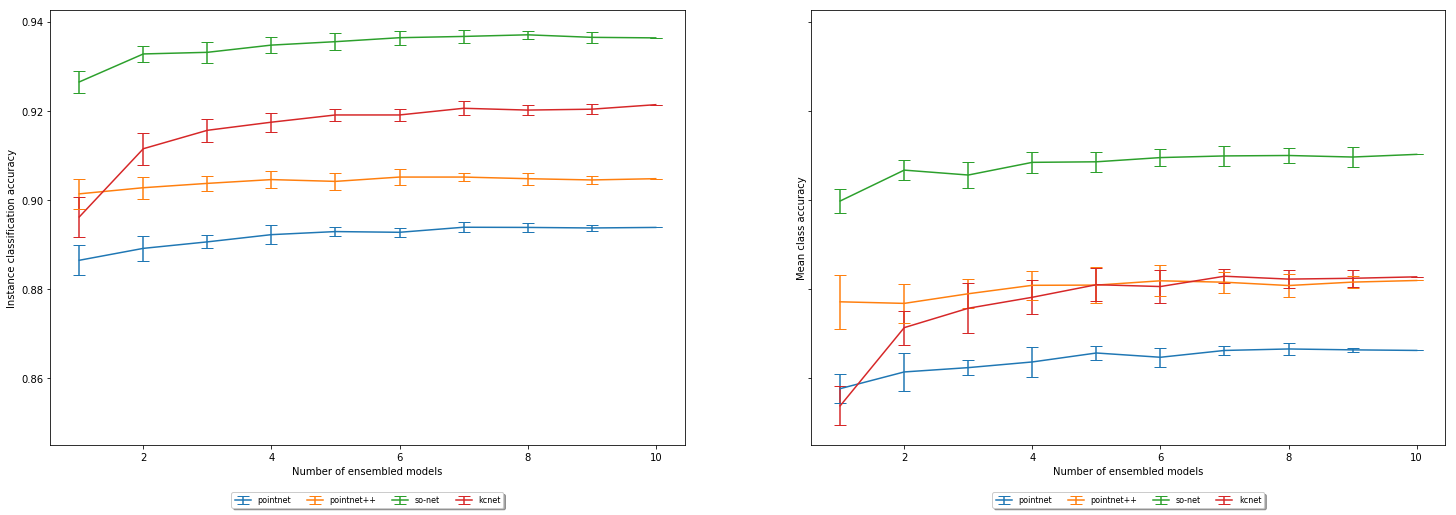

In [5]:
acc_stats_base_models = get_accuracy_stats(BASE_MODELS)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25, 10))
plot_acc_in_num_models(ax1, acc_stats_base_models, 'acc')
plot_acc_in_num_models(ax2, acc_stats_base_models, 'mean_class_acc')

## Accuracies in function of ensemled models for SO-Net bagging

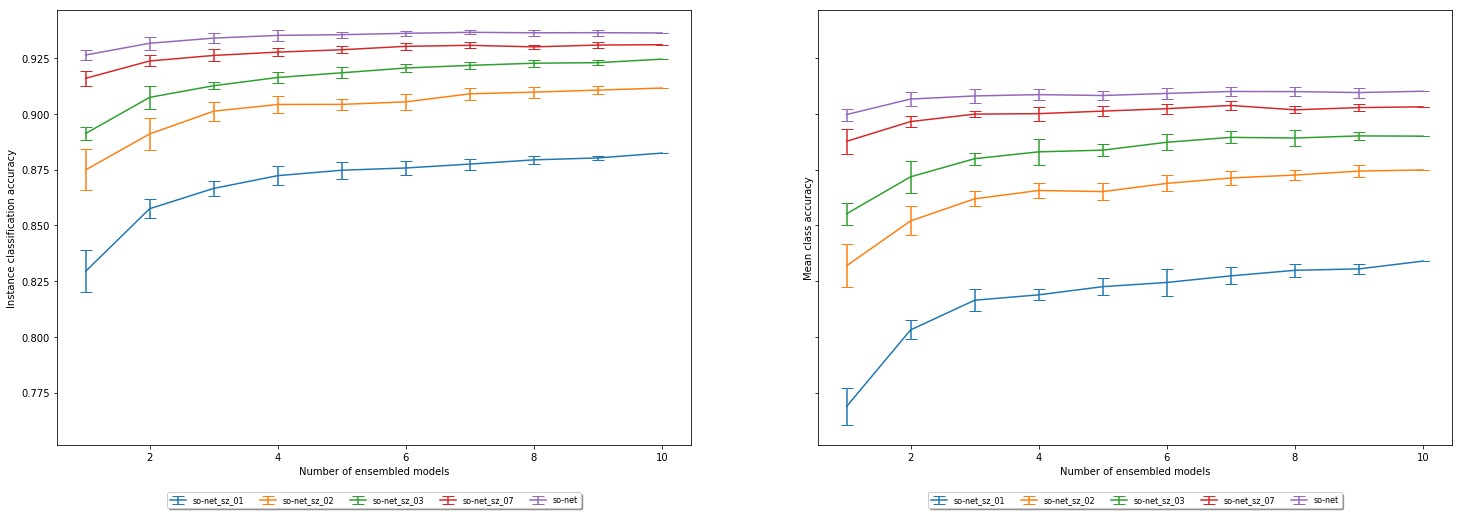

In [6]:
acc_stats_sonet_bagging = get_accuracy_stats(SONET_BAGGIBG_MODELS + ['so-net'])
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25, 10))
plot_acc_in_num_models(ax1, acc_stats_sonet_bagging, 'acc')
plot_acc_in_num_models(ax2, acc_stats_sonet_bagging, 'mean_class_acc')

## Compare results with and without ensemble

In [7]:
data = []
for model in BASE_MODELS:
    data.append([100 * acc_stats_base_models[model][1]['acc']['mean'],
                 100 * acc_stats_base_models[model][ENSEMBLE_MODELS_NUMBER]['acc']['mean'],
                 100 * acc_stats_base_models[model][1]['mean_class_acc']['mean'],
                 100 * acc_stats_base_models[model][ENSEMBLE_MODELS_NUMBER]['mean_class_acc']['mean']])
pd.options.display.float_format = '{:,.2f}%'.format
df = pd.DataFrame(data, columns=['Plain acc mean', 'Ensemble acc mean', 
                                 'Plain class acc mean', 'Ensemble class acc mean'], index=BASE_MODELS)
df['Increase acc'] = df['Ensemble acc mean'] - df['Plain acc mean']
df['Increase class acc'] = df['Ensemble class acc mean'] - df['Plain class acc mean']
df

,Plain acc mean,Ensemble acc mean,Plain class acc mean,Ensemble class acc mean,Increase acc,Increase class acc
pointnet,88.65%,89.38%,85.77%,86.62%,0.74%,0.86%
pointnet++,90.14%,90.48%,87.71%,88.19%,0.34%,0.48%
so-net,92.65%,93.64%,89.98%,91.02%,0.99%,1.05%
kcnet,89.62%,92.14%,85.38%,88.28%,2.52%,2.89%


## Test for best model selection

In [8]:
def test_result_for_validation_max(model_name):
    print('Caclutaing', model_name)
    mean_acc = 100 * acc_stats_base_models[model_name][1]['acc']['mean']
    max_acc = 100 * acc_stats_base_models[model_name][1]['acc']['max']
    
    indices = {}
    for k in range(40):
        indices[k] = [i for i, x in enumerate(true_labels[model_name]) if x == k]
    validation_max_res = []
    test_res_at_validation_max = []

    for _ in range(1000):
        validation_indices = []
        test_indices = []
        for k in indices:
            random.shuffle(indices[k])
            split_idx = int(len(indices[k])/2)
            validation_indices += indices[k][:split_idx]
            test_indices += indices[k][split_idx:]
        validation_indices = sorted(validation_indices)
        test_indices = sorted(test_indices)

        validation_true_labels = true_labels[model_name][validation_indices]
        validation_probabilities = probabilities[model_name][:, validation_indices]
        test_true_labels = true_labels[model_name][test_indices]
        test_probabilities = probabilities[model_name][:, test_indices]

        validation_predictions = np.argmax(validation_probabilities, axis=2)
        validation_compare = np.equal(validation_predictions, np.expand_dims(validation_true_labels, 0))
        validation_accuracies = np.mean(validation_compare, axis=1)

        test_predictions = np.argmax(test_probabilities, axis=2)
        test_compare = np.equal(test_predictions, np.expand_dims(test_true_labels, 0))
        test_accuracies = np.mean(test_compare, axis=1)

        validation_max_res.append(np.max(validation_accuracies))
        test_res_at_validation_max.append(test_accuracies[np.argmax(validation_accuracies)])

    mean_valid_max = 100 * statistics.mean(validation_max_res)
    mean_test_at_valid_max = 100 * statistics.mean(test_res_at_validation_max)

    return [mean_acc, max_acc, mean_valid_max, mean_test_at_valid_max]
    
data = []
for model in BASE_MODELS:
    data.append(test_result_for_validation_max(model))
pd.DataFrame(data, 
             columns=['Mean acc', 'Max acc', 'Mean of max valid acc', 'Mean of test acc at valid max'],
             index=BASE_MODELS)

Caclutaing pointnet
Caclutaing pointnet++
Caclutaing so-net
Caclutaing kcnet


,Mean acc,Max acc,Mean of max valid acc,Mean of test acc at valid max
pointnet,88.65%,89.06%,89.22%,88.61%
pointnet++,90.14%,90.64%,90.77%,90.34%
so-net,92.65%,92.95%,93.19%,92.47%
kcnet,89.62%,90.40%,90.52%,89.86%
